In [21]:
from IPython.display import display
import scienceplots,scipy
from itertools import combinations
#from model_selection import *
import urllib.request
import os, time
import numpy as np
import matplotlib.pyplot as plt
import sys  
import tarfile
import pandas as pd
import glob
from scipy import  signal
import math
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, freqz
from sklearn import *




In [ ]:
dir = os. getcwd()
print(dir)
src_path = 'nina.tar.gz'
dst_path = os.path.join(dir,'data')
urllib.request.urlretrieve('https://www.dropbox.com/s/kxrqhqhcz367v77/nina.tar.gz?dl=1', "nina.tar.gz")
if src_path.endswith('tar.gz'):
    tar = tarfile.open(src_path, 'r:gz')
    tar.extractall(dst_path)
    tar.close()

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def zero_lag_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data, padlen=15)
    return y

def data_preprocess(emg_data,fs,lowcut,highcut):
    print('Data filtering...')
    emg_ = zero_lag_filter(emg_data, lowcut, highcut, fs, order=4)
    #emg_ = abs(emg_)
    scaler = preprocessing.MinMaxScaler()
    emg_scaled = scaler.fit_transform(emg_)
    return emg_scaled

def features(data, epoch):
    print('Feature extraction...')
    number_of_segments = math.trunc(len(data) / epoch)
    splitted_data = np.split(data[0:number_of_segments * epoch, :], number_of_segments)
    RMS = np.empty([number_of_segments, data.shape[1]])
    MAV = np.empty([number_of_segments, data.shape[1]])
    IAV = np.empty([number_of_segments, data.shape[1]])
    VAR = np.empty([number_of_segments, data.shape[1]])
    WL = np.empty([number_of_segments, data.shape[1]])
    MF = np.empty([number_of_segments, data.shape[1]])
    PF = np.empty([number_of_segments, data.shape[1]])
    MP = np.empty([number_of_segments, data.shape[1]])
    TP = np.empty([number_of_segments, data.shape[1]])
    SM = np.empty([number_of_segments, data.shape[1]])
    # max_ind = np.empty([number_of_segments, 4])
    for i in range(number_of_segments):
        RMS[i, :] = np.sqrt(np.mean(np.square(splitted_data[i]), axis=0))
        # max_ind [i,:] = RMS[i,:][np.argpartition(RMS[i,:],5, axis=0)]
        MAV[i, :] = np.mean(np.abs(splitted_data[i]), axis=0)
        IAV[i, :] = np.sum(np.abs(splitted_data[i]), axis=0)
        VAR[i, :] = np.var(splitted_data[i], axis=0)
        WL[i, :] = np.sum(np.diff(splitted_data[i], prepend=0), axis=0)
        freq, power = signal.periodogram(splitted_data[i], axis=0)
        fp = np.empty([len(freq), power.shape[1]])
        for k in range(len(freq)):
            fp[k] = power[k, :] * freq[k]
        MF[i, :] = np.sum(fp, axis=0) / np.sum(power, axis=0)  # Mean frequency
        PF[i, :] = freq[np.argmax(power, axis=0)]  # Peak frequency
        MP[i, :] = np.mean(power, axis=0)  # Mean power
        TP[i, :] = np.sum(power, axis=0)  # Total power
        SM[i, :] = np.sum(fp, axis=0)  # Spectral moment
    print('Feature extraction is completed')
    return RMS, MAV, IAV, VAR, WL, MF, PF, MP, TP, SM

def labels(data, epoch):
    number_of_segments = math.trunc(len(data) / epoch)
    splitted_data = np.split(data[0:number_of_segments * epoch], number_of_segments)
    class_value = np.empty([number_of_segments])
    for i in range(number_of_segments):
        class_value[i] = np.rint(np.sqrt(np.mean(np.square(splitted_data[i]))))
    return class_value

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def classifier(features,labels,k_fold,models):
    Y = labels
    X = features
    number_of_k_fold = k_fold
    random_seed = 42
    outcome = []
    model_names = []
    # Variables for average classification report
    originalclass = []
    classification = []
    for model_name, model in models:
        k_fold_validation = model_selection.KFold(n_splits=number_of_k_fold, random_state=random_seed, shuffle=True)
        results = model_selection.cross_val_score(model, X, Y, cv=k_fold_validation,
                                                  scoring='accuracy')
        outcome.append(results)
        model_names.append(model_name)
        output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
        print(output_message)
    print(classification)
    fig = plt.figure()
    fig.suptitle('Machine Learning Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(outcome)
    plt.ylabel('Accuracy')
    plt.xlabel('Models')
    ax.set_xticklabels(model_names)
    fig2 = plt.figure()
    plt.show()
    
def get_data(subject,exercise):
    directories=glob.glob("data/**/**/*.mat")
    ends_with = f'S{subject}_E{exercise}_A1.mat'
    new_directories = [dir for dir in directories if dir.endswith(ends_with)]
    mat = scipy.io.loadmat(new_directories[0])
    mat_ks = [k for k in mat.keys()]
    print((mat_ks))
    df = pd.DataFrame.from_dict(mat.items())
    display(df.T.head())
    emg = df.loc[3][1]

    stimulus = df.loc[10][1]
    glove = df.loc[6][1]
    # If you want to perform some elimination with the labels
    # stimulus_p = np.nan_to_num(stimulus)
    # print(np.where(stimulus==0))
    # stimulus=np.delete(stimulus_p,np.where(stimulus_p==0))
    #
    # emg_new=np.delete(emg,np.where(stimulus_p==0), axis=0)
    # emg=emg_new

    
    return emg,stimulus,glove

In [26]:
exercise = 3
subject = 2
emg, stimulus, glove = get_data(subject, exercise)
print(emg.shape,stimulus.shape,glove.shape)
# Filtering
fs = 200
lowcut = 20
highcut = 80
print(emg)
emg = data_preprocess(emg,fs,lowcut,highcut)
print(emg.shape)
print(emg)

['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition', 'age', 'circumference', 'frequency', 'gender', 'height', 'weight', 'laterality', 'sensor']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,__header__,__version__,__globals__,emg,acc,stimulus,glove,subject,exercise,repetition,restimulus,rerepetition,age,circumference,frequency,gender,height,weight,laterality,sensor
1,"b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...",1.0,[],"[[12.0, 2.0, 2.0, 1.0, -1.0, -2.0, -3.0, 1.0, ...","[[-0.11669922, 0.8959961, -0.4189453], [-0.116...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[65.94792, -22.281229, 18.465925, -9.411551, ...",[[11]],[[2]],"[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ...",[[28]],[[26]],[[200]],[m],[[187]],[[75]],[r],[Double Myo]


(292932, 16) (292932, 1) (292932, 22)
[[ 12.   2.   2. ...   0.   0.   0.]
 [-10.  -2.  -3. ...  -1.  -3.   0.]
 [ -9.  -4.   0. ...  -1.  -2.  -5.]
 ...
 [  1. -11. -17. ...  -5.   0.  -2.]
 [  3.   8.  14. ...  -3.  -2.   2.]
 [  0.   0.  -9. ...  -2.  -3.  -7.]]
Data filtering...
(292932, 16)
[[0.52142437 0.51090697 0.50079321 ... 0.52269716 0.51278637 0.4698488 ]
 [0.52841672 0.54545355 0.51607486 ... 0.51720372 0.50477486 0.43828138]
 [0.51569057 0.53641346 0.5214879  ... 0.52039209 0.51511425 0.44134509]
 ...
 [0.55757619 0.49194405 0.4514774  ... 0.52446973 0.53667265 0.49250978]
 [0.53523465 0.54416921 0.54775214 ... 0.50764559 0.50333981 0.43226593]
 [0.51038337 0.53179484 0.48561751 ... 0.53366968 0.52146313 0.46399514]]


(292932, 16) (292932, 12)
0.9999859918565436
[0.29562953 0.47044747 0.58261128 0.68245767 0.76959196 0.85485103
 0.9115972  0.95165573 0.98294255 0.99699376 0.99996072 0.99998599]


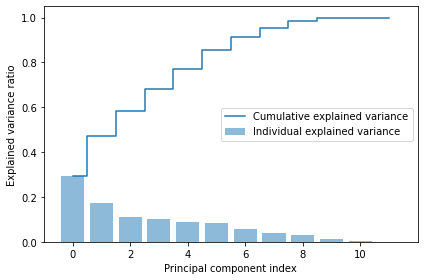

In [4]:
pca_x = PCA(n_components=12)

emg_new = pca_x.fit_transform(emg)
print(emg.shape,emg_new.shape)
exp_var_pca = pca_x.explained_variance_ratio_
print(np.sum(exp_var_pca))
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
print(cum_sum_eigenvalues)

plt.figure(0)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
emg=emg_new

In [18]:
epoch = 50
RMS, MAV, IAV, VAR, WL, MF, PF, MP, TP, SM = features(emg, epoch)
feature_set = {'rms': RMS, 'mav': MAV, 'iav': IAV, 'var': VAR,
                   'wl': WL, 'mf': MF, 'pf': PF, 'mp': MP,
                   'tp': TP, 'sm': SM}
feature_set = pd.DataFrame.from_dict(feature_set.items()).reset_index()
feature_set_xarray = np.squeeze([[feature_set.loc[i][1]] for i in range(feature_set.shape[0])])
label_array = signal_features.labels(stimulus, epoch)
label_array = np.nan_to_num(label_array)
feature_set_xarray_n = feature_set_xarray.reshape(feature_set_xarray.shape[1],
                                                      feature_set_xarray.shape[0] * feature_set_xarray.shape[2])
print(feature_set.shape,feature_set_xarray_n.shape,label_array.shape)


Feature extraction...
(10, 3) (5858, 160) (5858,)


C:\Users\batua\PycharmProjects\NCMLapp\prev\signal_features.py:109: RuntimeWarning: invalid value encountered in sqrt
  class_value[i] = np.rint(np.sqrt(np.mean(np.square(splitted_data[i]))))


Classifier function can be used to compare different classifier performances.

In [11]:
models = [('LogReg', LogisticRegression(max_iter=1000)),
              ('SVM', SVC()),
              ('DecTree', DecisionTreeClassifier()),
              ('KNN', KNeighborsClassifier(n_neighbors=15)),
              ('LinDisc', LinearDiscriminantAnalysis()),
              ('GaussianNB', GaussianNB()),
              ('MLPC', MLPClassifier(activation='relu', solver='adam', max_iter=500)),
              ('RFC',RandomForestClassifier()),
              ('ABC', AdaBoostClassifier())
              ]

LogReg| Mean=0.743942 STD=0.007374
SVM| Mean=0.751623 STD=0.006929
DecTree| Mean=0.613863 STD=0.006655
KNN| Mean=0.748550 STD=0.005189
LinDisc| Mean=0.716458 STD=0.008364
GaussianNB| Mean=0.269886 STD=0.006820


C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPC| Mean=0.722944 STD=0.008314
RFC| Mean=0.749063 STD=0.008109
ABC| Mean=0.592033 STD=0.182208
[]


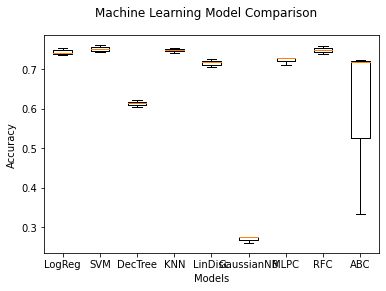

<Figure size 432x288 with 0 Axes>

In [12]:
n_folds = 3 # Number of k-fold
classifier(feature_set_xarray_n, label_array, n_folds, models)

In the following part, we can select the best model and feature set combination. The algorithm works with trial and error approach to find the best model and feature set combination. It also uses k-fold cross validation to be able to better understand performance of selected models. Note that, it tries all possible configurations so that as number of models and n_folds increases the computation time increases.

In [ ]:
models = [('SVM', SVC()),
          ('KNN', KNeighborsClassifier(n_neighbors=15)),
              ]
n_folds = 2 # Number of k-fold
min_accuracy = 0.75
results=[]
# Initialize variables to store the best model and its performance
best_model = []
best_accuracy = 0
# Feature and model selection selection
for i in range(1, feature_set.shape[0]):
    for features in combinations(range(10), i):
        feature_names = [feature_set[0][k] for k in features]
        feature_idx = features
        cur_X = feature_set_xarray[features, :, :]
        cur_X = cur_X[~np.isnan(cur_X)].reshape(cur_X.shape[1], cur_X.shape[0] * cur_X.shape[2])

        # print(cur_X.shape)
        # X_train, X_test, y_train, y_test = train_test_split(cur_X, labels, test_size=0.2)
        for train_idx, test_idx in KFold(n_folds).split(cur_X):
            X_train, X_test = cur_X[train_idx], cur_X[test_idx]
            y_train, y_test = label_array[train_idx], label_array[test_idx]
            # Iterate over the models
            for model_name, model in models:
                start_time = time.time()
                # Fit the model on the training data
                model.fit(X_train, y_train)
                
                end_time = time.time()
                execution_time = round(end_time - start_time, 4)
                # Evaluate the model on the test data
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                accuracy = round(accuracy,4)
                # f1 = f1_score(y_test, y_pred)
                print(f'{model_name}, with {len(feature_names)} feature(s), Accuracy: {accuracy}')
                results.append([model_name, feature_names, accuracy, execution_time])
                # Update the best model and its performance if necessary
                if accuracy >= min_accuracy or accuracy >= best_accuracy:
                    best_model= [model_name, feature_names, accuracy, model]
                    print('New good performance!')         
                    print('-------------')
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model_name = model_name
                        best_features = feature_names
                        print(f'New best performance! :{model_name}')
                        print('Model: {}'.format(model_name))
                        print('Features: {}'.format(feature_names))
                        print('Accuracy: {}'.format(accuracy))
                        print('Training time: {}'.format(execution_time))
                        print('-------------')

SVM, with 1 feature(s), Accuracy: 0.6644
New good performance!
-------------
New best performance! :SVM
Model: SVM
Features: ['rms']
Accuracy: 0.6644
Training time: 0.0893
-------------
KNN, with 1 feature(s), Accuracy: 0.6681
New good performance!
-------------
New best performance! :KNN
Model: KNN
Features: ['rms']
Accuracy: 0.6681
Training time: 0.001
-------------
SVM, with 1 feature(s), Accuracy: 0.8129
New good performance!
-------------
New best performance! :SVM
Model: SVM
Features: ['rms']
Accuracy: 0.8129
Training time: 0.1509
-------------
KNN, with 1 feature(s), Accuracy: 0.7416
SVM, with 1 feature(s), Accuracy: 0.6644
KNN, with 1 feature(s), Accuracy: 0.664
SVM, with 1 feature(s), Accuracy: 0.8378
New good performance!
-------------
New best performance! :SVM
Model: SVM
Features: ['mav']
Accuracy: 0.8378
Training time: 0.1621
-------------
KNN, with 1 feature(s), Accuracy: 0.7907
New good performance!
-------------
SVM, with 1 feature(s), Accuracy: 0.6644
KNN, with 1 featu

SVM, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 2 feature(s), Accuracy: 0.6644
KNN, with 2 feature(s), Accuracy: 0.6644
SVM, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 2 feature(s), Accuracy: 0.6644
KNN, with 2 feature(s), Accuracy: 0.6644
SVM, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 2 feature(s), Accuracy: 0.6644
KNN, with 2 feature(s), Accuracy: 0.6644
SVM, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 2 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 2 feature(s), Accuracy: 0.6644
KNN, with 2 feature(s), Accuracy: 0.6617
SVM, with 2 feature(s), Accuracy: 0.8389
New good perfor

SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8382
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.4083
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8348
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 

SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8368
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 fea

SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6644
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8296
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.2533
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.2533
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.6576
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8351
New good performance!
-------------
SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 fea

SVM, with 3 feature(s), Accuracy: 0.6644
KNN, with 3 feature(s), Accuracy: 0.5504
SVM, with 3 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 3 feature(s), Accuracy: 0.8334
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8351
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 fea

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8296
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8293
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8296
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8296
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 fea

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 fea

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8354
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6637
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8358
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 fea

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6637
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8368
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 fea

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.664
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8354
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feat

SVM, with 4 feature(s), Accuracy: 0.6644
KNN, with 4 feature(s), Accuracy: 0.6644
SVM, with 4 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 4 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 fea

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8351
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8351
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.833
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.661
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8348
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8341
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8351
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.664
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8375
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.833
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.661
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8348
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8341
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.833
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.661
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8348
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8341
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6603
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8361
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 featu

SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 feature(s), Accuracy: 0.6644
SVM, with 5 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 5 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 5 feature(s), Accuracy: 0.6644
KNN, with 5 fea

SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 fea

SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8382
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8385
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8371
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 fea

SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8371
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 fea

SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6644
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6501
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8382
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.6528
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8371
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feature(s), Accuracy: 0.663
SVM, with 6 feature(s), Accuracy: 0.8389
New good performance!
-------------
KNN, with 6 feature(s), Accuracy: 0.8378
New good performance!
-------------
SVM, with 6 feature(s), Accuracy: 0.6644
KNN, with 6 feat